In [18]:
import sys
#sys.path.append('/usr/local/lib/python3.9/site-packages') 
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, sin, cos, lambdify, exp, asin, sqrt, Abs, Derivative
import cvxopt as cvxopt
from shapely.geometry import Polygon, Point
#import shapely.affinity as affinity
import random
import math

In [19]:
# TF packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

#### Functions

In [20]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['maxiters'] = 100
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

def calc_distance_and_angle(x0, xg):
        dx = xg - x0
        d = math.hypot(dx[0], dx[1])
        theta = math.atan2(dx[1], dx[0])
        return d, theta

def interval_sample(min_x, max_x, res = 1):
        return (((max_x) - (min_x))/res)*np.random.randint(0, res) + (min_x)

def angular_diff(x,y): #angular difference
        d = y-x
        return math.atan2(math.sin(d), math.cos(d))
    
def zero_2pi_adj(theta):
    if theta > 2*np.pi:
        temp = theta/(2*np.pi)-1
        k = math.ceil(temp)
        theta = theta -k*2*np.pi
    elif theta <0:
        temp = -theta/(2*np.pi)
        k = math.ceil(temp)
        theta = theta +k*2*np.pi
    return theta

def pi_pi_adj(theta):
    if theta > np.pi:
        temp = theta/(2*np.pi)-0.5
        k = math.ceil(temp)
        theta = theta -k*2*np.pi
    elif theta <-np.pi:
        temp = -theta/(2*np.pi)-0.5
        k = math.ceil(temp)
        theta = theta +k*2*np.pi
    return theta

def calc_angle(from_x, to_x):
        dx = to_x[0:2] - from_x[0:2]
        d = math.hypot(dx[0], dx[1])
        theta = math.atan2(dx[1], dx[0])
        return zero_2pi_adj(theta)
    
def OPT(V, LfV, LgV, x0, xg, gamma = 0, v_gain = 1.2, w_gain = 1):
    # robot spec
    v_max = 1.
    v_min = 0.
    w_max = .5
    w_min = -.5

    # generate input sample
    dist_goal, theta_goal = calc_distance_and_angle(x0, xg)
    u_ref = np.array([0,0],'f')
    u_ref[0] = np.exp(-v_gain/dist_goal)*v_max
    u_ref[1] = w_gain*angular_diff(x0[2], theta_goal)

    # OPT formulate: min 0.5*u'Hu s.t. Nu<=m
    A = np.zeros((6,3))
    b = np.zeros((6,1))

    ## lyapanov
    A[0,0:2] = LgV(x0)
    A[0,2] = -1
    b[0] = -LfV(x0)
    #slack variabl of lyapanov
    A[1,2] = -1

    ## Control constraints
    A[2,0] = 1.
    b[2] = v_max
    A[3,0] =- 1.
    b[3] = -v_min
    A[4,1] = 1.
    b[4] = w_max
    A[5,1] = -1.
    b[5] = -w_min

    H = np.zeros((3, 3))
    ff = np.zeros((3, 1))
    H[0,0] = 10
    H[1,1] = 10
    H[2,2] = 0
    ff[0] = -10*u_ref[0]
    ff[1] = -10*u_ref[1]
    ff[2] = 6
    uq = cvxopt_solve_qp(H, ff, A, b)
    
    return uq[0:2]

def traj_gen(x0, x0_NN, xg, V, LfV, LgV, controller, iteration = 40, mode = 'NN'):  # modes: 'NN' and 'OPT'
    traj_x = []
    traj_x_NN = []
    traj_u = []
    
    traj_x.append(x0)
    traj_x_NN.append(x0_NN)
    
    if mode == 'NN':
        for j in range(iteration):
            u = controller.predict(np.array([x0_NN])).flatten()
            x_dot = (Real_x_r(x0,u[0:2])).flatten()
            x0 = (T*Real_x_r(x0,u[0:2])).flatten()+x0
            x0[2] = pi_pi_adj(x0[2])
            x0_NN = reg_2_NN_coord(x0)

            traj_u.append(u)
            traj_x.append(x0)
            traj_x_NN.append(x0_NN)
        
        traj_u.append(u)
        
        traj_x = np.array(traj_x)
        traj_x_NN = np.array(traj_x_NN)
        traj_u = np.array(traj_u)
    else: 
        while (np.linalg.norm(x0[0:2]-xg[0:2]))>xg[2]:
            u = controller(V, LfV, LgV, x0, xg) 
            x_dot = (Real_x_r(x0,u)).flatten()
            x0 = (T*Real_x_r(x0,u)).flatten()+x0
            x0[2] = pi_pi_adj(x0[2])
            x0_NN = reg_2_NN_coord(x0)

            traj_u.append(u)
            traj_x.append(x0)
            traj_x_NN.append(x0_NN)
        
        traj_u.append(u)
        
        traj_x = np.array(traj_x)
        traj_x_NN = np.array(traj_x_NN)
        traj_u = np.array(traj_u)
        
        temp = np.array([np.linspace(0., 1.0, num = traj_u.shape[0])])
        traj_u = np.concatenate((traj_u, temp.T), axis=1)
        
    return traj_x, traj_x_NN, traj_u
def reg_2_NN_coord(x):
    x_NN = np.zeros((4))
    x_NN[0] = x[0]
    x_NN[1] = x[1]
    x_NN[2] = math.sin(x[2])
    x_NN[3] = math.cos(x[2])

    return x_NN

def sample_generate(x_interval):
    x = np.zeros((3))
    x[0] = interval_sample(x_interval[0][0],x_interval[0][1],300)
    x[1] = interval_sample(x_interval[1][0],x_interval[1][1],300)
    x[2] = interval_sample(x_interval[2][0],x_interval[2][1],6)
    
    x_NN = reg_2_NN_coord(x)
    return x, x_NN

In [21]:
def OPT2(V, LfV, LgV, h, Lfh, Lgh, x0, xg, gamma = 0, alpha = 10, v_gain = 1.2, w_gain = 1): ## added curve around obstacle
    # robot spec
    v_max = 1.
    v_min = 0.
    w_max = .5
    w_min = -.5

    # generate input sample
    dist_goal, theta_goal = calc_distance_and_angle(x0, xg)
    u_ref = np.array([0,0],'f')
    u_ref[0] = np.exp(-v_gain/dist_goal)*v_max
    u_ref[1] = w_gain*angular_diff(x0[2], theta_goal)

    # OPT formulate: min 0.5*u'Hu s.t. Nu<=m
    A = np.zeros((8,4))
    b = np.zeros((8,1))

    ## lyapanov
    A[0,0:2] = LgV(x0)
    A[0,2] = -1
    b[0] = -LfV(x0)
    #slack variabl of lyapanov
    A[1,2] = -1

    ## safety constraints
    t_g = calc_angle(x0,xo)
    A[2,0:2] = -Lgh(x0,t_g)
    A[2,3] = -1
    b[2] = Lfh(x0,t_g) + alpha * h(x0,t_g)
    #slack variabl of lyapanov
    A[3,3] = -1

    ## Control constraints
    A[4,0] = 1.
    b[4] = v_max
    A[5,0] =- 1.
    b[5] = -v_min
    A[6,1] = 1.
    b[6] = w_max
    A[7,1] = -1.
    b[7] = -w_min
    
    

    H = np.zeros((4, 4))
    ff = np.zeros((4, 1))
    H[0,0] = 10
    H[1,1] = 10
    H[2,2] = 0
    H[3,3] = 0
    ff[0] = -10*u_ref[0]
    ff[1] = -10*u_ref[1]
    ff[2] = 2
    ff[3] = 6
    uq = cvxopt_solve_qp(H, ff, A, b)
    
    return uq, A, b

#### parameters

In [22]:
T = 0.5
l = 0.01
x_g_s = np.array([0,0,0.2])
r = 0.3
xg = np.array([0,0,0.2])
xo = np.array([-2,-2,0.2])
x0_interval = [(-5,-3),(-5,-3),(0,np.pi/2)] # x0 = [x,y,theta] intervals

#### Bicycle model

In [23]:
# symbolize the control
xr1,xr2,xr3,theta_g = symbols('xr1 xr2 xr3 theta_g')  
u1,u2 = symbols('u1,u2')

# Vector of states and inputs + g and f:
x_r_s = Matrix([xr1,xr2,xr3]) #robot state [x,y,theta]
u_s = Matrix([u1,u2])         #control [v,w]
f = Matrix([0.,0.,0.])
g = Matrix([[cos(x_r_s[2]), -l*sin(x_r_s[2])], [sin(x_r_s[2]), l*cos(x_r_s[2])], [0., 1.]])
f_r = f + g*u_s 
Real_x_r = lambdify([x_r_s, u_s], Matrix([[cos(x_r_s[2]), 0.], [sin(x_r_s[2]), 0.], [0., 1.]])*u_s, 'numpy') #???

#### Lyapanov constraint

In [24]:
V = (x_r_s[0]-x_g_s[0])**2+(x_r_s[1]-x_g_s[1])**2-(l)**2
V_d = V.diff(Matrix([x_r_s]))
V = lambdify([x_r_s], V)
LfV = lambdify([ x_r_s], V_d.T*f)
LgV = lambdify([ x_r_s], V_d.T*g)

#### CBF constraint

In [25]:
CBF = (x_r_s[0] - xo[0])**2 + (x_r_s[1] - xo[1])**2 - (r + xo[2] + l)**2
CBF_d = CBF.diff(Matrix([x_r_s]))
h = lambdify([x_r_s], CBF)
Lfh = lambdify([x_r_s], CBF_d.T*f)
Lgh = lambdify([x_r_s], CBF_d.T*g)

#### expinential CBF

In [26]:
lamda = 1
CBF6 = exp(-lamda*CBF)

CBF_d6 = CBF6.diff(Matrix([x_r_s]))
B = lambdify([x_r_s], CBF6)
LfB = lambdify([x_r_s], CBF_d6.T*f)
LgB = lambdify([x_r_s], CBF_d6.T*g) # LgB*u <= -alpha*(B(x)-1) - LfB

In [27]:
def calc_angle(from_x, to_x):
    dx = to_x[0:2] - from_x[0:2]
    d = math.hypot(dx[0], dx[1])
    theta = math.atan2(dx[1], dx[0])
    return zero_2pi_adj(theta)

#### If $\theta_g - \theta \geq 0$

In [28]:
CBF2 = -(theta_g - x_r_s[2] - asin(xo[2]/sqrt((x_r_s[0]-xo[0])**2+(x_r_s[1]-xo[1])**2)))*(-theta_g + x_r_s[2] - asin(xo[2]/sqrt((x_r_s[0]-xo[0])**2+(x_r_s[1]-xo[1])**2)))*((x_r_s[0] - xo[0])**2 + (x_r_s[1] - xo[1])**2 - (r + xo[2] + l)**2)       #>\pi/2
CBF_d2 = CBF2.diff(Matrix([x_r_s]))
h2 = lambdify([x_r_s,theta_g], CBF2)
Lfh2 = lambdify([x_r_s,theta_g], CBF_d2.T*f)
Lgh2 = lambdify([x_r_s,theta_g], CBF_d2.T*g)


In [29]:
xx = np.array([-2., -2.6,  1.6])
t_g = calc_angle(xx,xo)
temp = t_g-xx[2]
gamma2 = 5
print("xo: {}".format(xo))
print("x: {}".format(xx))
print("t_g: {}".format(t_g))
print("angle difference: {}".format(temp))
print('h: {}'.format(h(xx)))
print('h2: {}'.format(h2(xx,t_g)))
print('h2 const: {} * u1 + {} * u2 >= {}'.format(Lgh2(xx,t_g)[0][0], Lgh2(xx,t_g)[0][1],-gamma2*h2(xx,t_g)))


xo: [-2.  -2.   0.2]
x: [-2.  -2.6  1.6]
t_g: 1.5707963267948966
angle difference: -0.02920367320510353
h: 0.0999000000000001
h2: -0.011452163422816004
h2 const: 0.09751181442247232 * u1 + 0.005806408776408231 * u2 >= 0.05726081711408002


In [30]:
Lgh2(xx,t_g)[0]

array([0.09751181, 0.00580641])

[1. 0.]


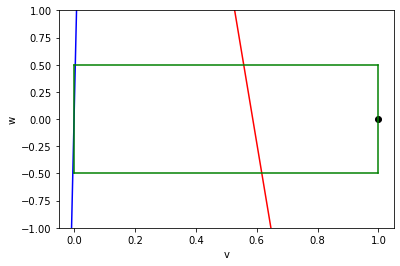

In [31]:
def draw(a, b, c):   # ax + by + c = 0
    x1 = -1.
    x2 = 1.

    y1 = (-c - a*x1) / b
    y2 = (-c - a*x2) / b

    x = np.array([x1,x2])
    y = np.array([y1,y2])

    return x, y
    
#lyapanov
a1 = LgV(xx)[0][0]
b1 = LgV(xx)[0][1]
c1 = LfV(xx)[0][0]
x1, y1 = draw(a1, b1, c1)

#safety
a2 = Lgh2(xx,t_g)[0][0]
b2 = Lgh2(xx,t_g)[0][1]
c2 = gamma2*h2(xx,t_g)
x2, y2 = draw(a2, b2, c2)


points = [np.array([0.3,0.5]), np.array([1.,0.]), np.array([0.,0.5]), np.array([0,-0.5])]

for pt in points:
    if (a1*pt[0]+b1*pt[1]+c1<=0) and (a2*pt[0]+b2*pt[1]+c2>=0):
        plt.scatter(pt[0],pt[1], color="black")
        print(pt)


plt.plot(x1,y1, color= "blue")
plt.plot(x2,y2, color="red")
plt.plot(np.array([0.,0.]),np.array([-.5,.5]), color="green")
plt.plot(np.array([1.,1.]),np.array([-.5,.5]), color="green")
plt.plot(np.array([0.,1.]),np.array([.5,.5]), color="green")
plt.plot(np.array([0.,1.]),np.array([-.5,-.5]), color="green")
plt.xlim(-0.05, 1.05)
plt.ylim(-1, 1)
plt.xlabel("v")
plt.ylabel("w")
plt.show()

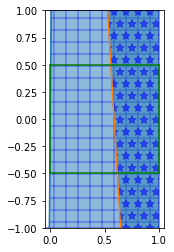

In [12]:
from scipy.spatial import HalfspaceIntersection

halfspaces = np.array([[-LgV(xx)[0][0], -LgV(xx)[0][1], -LfV(xx)[0][0]],
                       [Lgh2(xx,t_g)[0][0], Lgh2(xx,t_g)[0][1], gamma2*h2(xx,t_g)]])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xlim, ylim = (-0.05, 1.05), (-1, 1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

x = np.linspace(-1, 1, 100)

symbols = ['+', '*',]

signs = [0, -1]

fmt = {"color": None, "edgecolor": "b", "alpha": 0.5}

for h, sym, sign in zip(halfspaces, symbols, signs):

    hlist = h.tolist()

    fmt["hatch"] = sym

    if h[1]== 0:

        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}=0'.format(*hlist))

        xi = np.linspace(xlim[sign], -h[2]/h[0], 100)

        ax.fill_between(xi, ylim[0], ylim[1], **fmt)

    else:

        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}=0'.format(*hlist))

        ax.fill_between(x, (-h[2]-h[0]*x)/h[1], ylim[sign], **fmt)

ax.plot(np.array([0.,0.]),np.array([-.5,.5]), color="green")
ax.plot(np.array([1.,1.]),np.array([-.5,.5]), color="green")
ax.plot(np.array([0.,1.]),np.array([.5,.5]), color="green")
ax.plot(np.array([0.,1.]),np.array([-.5,-.5]), color="green")

In [32]:
xx = np.array([-2.54839482, -2.37988279,  2.8])
t_g = calc_angle(xx,xo)
temp = t_g-xx[2]
gamma = 0.4
gamma2 = 0.31
if temp>=0:
    print('h2 const: {} * u2 >= {}'.format(Lgh2(xx,t_g)[0][1],-gamma*h2(xx,t_g)))
    print('h3 const: {} * u2 >= {}'.format(Lgh3(xx,t_g)[0][1],-gamma*h3(xx,t_g)))
if temp<0:
    print('h4 const: {} * u2 >= {}'.format(Lgh4(xx,t_g)[0][1],-gamma2*h4(xx,t_g)))
    print('h5 const: {} * u2 >= {}'.format(Lgh5(xx,t_g)[0][1],-gamma2*h5(xx,t_g)))

NameError: name 'Lgh4' is not defined

In [464]:
Lgh2(xx,t_g)

array([[-1.37168568, -1.08807492]])

#### Initialize the NN

In [33]:
num_input = 4
num_output = 3
num_hidden_0 = 10
num_hidden_1 = 10
starter_learning_rate = 0.005
regularizer_rate = 0.001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(num_input,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))
model_orig.summary()

Model: "3_layer_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 10)                50        
                                                                 
 layer1 (Dense)              (None, 10)                110       
                                                                 
 output (Dense)              (None, 3)                 33        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


2021-12-07 15:53:41.290747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-07 15:53:41.849583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40877 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:d5:00.0, compute capability: 7.5


#### Define loss function

In [34]:
import tensorflow.keras.backend as kb
#define costum loss function
def keras_SSE_costum(y_actual, y_predicted):
    err = y_actual - y_predicted
    loss_value = kb.sum(kb.square(err))
    return loss_value

In [35]:
# define loss 
#loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = keras_SSE_costum,
                   metrics=['accuracy'])

#### Generate trajectories and train

#### Dagger Algorithm

In [36]:

trajectory = []
trajectory_NN = []
control = []
beta = 1 #
N_traj = 100

for i in range(N_traj):
    beta = (N_traj-i)/(N_traj) 
    print('Cycle {}'.format(i+1))
    x0,x0_NN = sample_generate(x0_interval)
    
    x_traj = []
    x_traj_NN = []
    u_traj = []
    x_traj.append(x0)
    x_traj_NN.append(x0_NN)

    # generate trajectory and train network
    while (np.linalg.norm(x0[0:2]-x_g_s[0:2]))>x_g_s[2]:
        u = OPT(V, LfV, LgV, x0, x_g_s)                # QP output
        u1 = model_orig.predict(np.array([x0_NN])).flatten() # NN output
        u_apply = beta*u + (1-beta)*u1[0:2]      # mix controls
        x_dot = (Real_x_r(x0,u_apply)).flatten()
        x0 = (T*Real_x_r(x0,u_apply)).flatten()+x0
        x0[2] = pi_pi_adj(x0[2])
        x0_NN = reg_2_NN_coord(x0)
        u_traj.append(u)
        x_traj.append(x0)
        x_traj_NN.append(x0_NN)
    u_traj.append(u)
    print('Trajectory {} is generated. Training time!!'.format(i+1))
    x_traj = np.array(x_traj)
    x_traj_NN = np.array(x_traj_NN)
    u_traj = np.array(u_traj)
    temp = np.array([np.linspace(0., 1.0, num = u_traj.shape[0])])
    u_traj = np.concatenate((u_traj, temp.T), axis=1)
    trajectory.append(x_traj)
    trajectory_NN.append(x_traj_NN)
    control.append(u_traj)


    # Train model for the generate sample
    his = model_orig.fit(np.concatenate(trajectory_NN), np.concatenate(control), epochs=2, use_multiprocessing = True, verbose = 0)
    
    print('----------------------------------------')

print('Done training!')


Cycle 1
Trajectory 1 is generated. Training time!!
----------------------------------------
Cycle 2
Trajectory 2 is generated. Training time!!
----------------------------------------
Cycle 3
Trajectory 3 is generated. Training time!!
----------------------------------------
Cycle 4
Trajectory 4 is generated. Training time!!
----------------------------------------
Cycle 5
Trajectory 5 is generated. Training time!!
----------------------------------------
Cycle 6
Trajectory 6 is generated. Training time!!
----------------------------------------
Cycle 7
Trajectory 7 is generated. Training time!!
----------------------------------------
Cycle 8
Trajectory 8 is generated. Training time!!
----------------------------------------
Cycle 9
Trajectory 9 is generated. Training time!!
----------------------------------------
Cycle 10
Trajectory 10 is generated. Training time!!
----------------------------------------
Cycle 11
Trajectory 11 is generated. Training time!!
-------------------------

KeyboardInterrupt: 

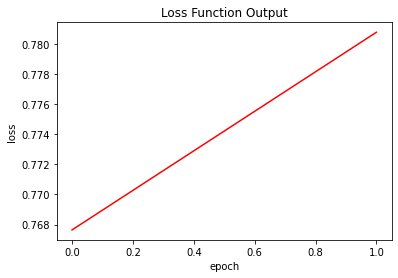

In [37]:
# plot loss function
results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### SeperatedTraining

#### Control design

In [709]:
# model_orig.save('model_3_out/my_model')

In [710]:
#model_orig.save_weights('saved_model10/weights')

In [711]:
#temp = keras.models.load_model('saved_model10/my_model', compile=False)

In [712]:
#model_orig = keras.models.load_model('saved_model6/my_model')

## load model

In [38]:
model_orig = keras.models.load_model('model_3_out/my_model',compile=False)

#### Performance on training data

In [39]:
final_trajectory = []
final_u = []
x0_interval = [(-5,-3),(-5,-3),(0,np.pi/2)] # x0 = [x,y,theta] intervals
for i in range(30):
    print('cycle: {}'.format(i+1))
    x0, x0_NN = sample_generate(x0_interval)
    traj_xx, traj_xx_NN, traj_uu = traj_gen(x0, x0_NN, x_g_s, V, LfV, LgV, model_orig, iteration = 60, mode = 'NN')
    final_trajectory.append(traj_xx)
    final_u.append(traj_uu)

cycle: 1
cycle: 2
cycle: 3
cycle: 4
cycle: 5


KeyboardInterrupt: 

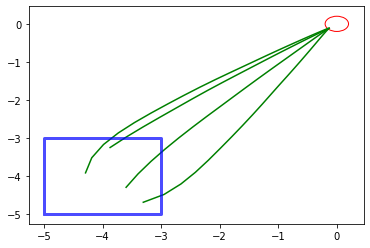

In [44]:
poly = Polygon([(x0_interval[0][0], x0_interval[1][0]), (x0_interval[0][0], x0_interval[1][1]), (x0_interval[0][1], x0_interval[1][1]), (x0_interval[0][1], x0_interval[1][0])])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
for traj in final_trajectory:
    plt.plot(traj[:,0],traj[:,1], color= 'green')
#for traj in trajectory:
#    plt.plot(traj[:,0],traj[:,1], color= 'red')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')

ax = plt.gca()
ax.add_patch(plt.Circle((x_g_s[0], x_g_s[1]), 0.2, color='red', fill=False))

In [ ]:
uu = final_u[6]
uu2 = control[6]
plt.plot(uu[:,1], color= 'green')
plt.plot(uu2[:,1], color= 'red')
plt.show()

NameError: name 'control' is not defined

### Add safety constraint and just retrain the last layer

In [158]:
CBF_d.T*g

Matrix([[(2.0*xr1 + 4.0)*cos(xr3) + (2.0*xr2 + 4.0)*sin(xr3), -(2.0*xr1 + 4.0)*sin(xr3) + (2.0*xr2 + 4.0)*cos(xr3)]])

In [40]:
trajec = []
# x0, _ = sample_generate(x0_interval)
x0 = np.array([-4.07333333,-3.96666667, 0.])
trajec.append(x0)
while (np.linalg.norm(x0[0:2]-x_g_s[0:2]))>x_g_s[2]:
    u_apply, _, _ = OPT2(V, LfV, LgV, h2, Lfh2, Lgh2, x0, x_g_s, gamma = 0, alpha = 1, v_gain = 1.2, w_gain = 1)
    x_dot = (Real_x_r(x0,u_apply[0:2])).flatten()
    x0 = (T*Real_x_r(x0,u_apply[0:2])).flatten()+x0
    x0[2] = pi_pi_adj(x0[2])
    print(x0)
    trajec.append(x0)
trajec = np.stack(trajec,0)

[-3.72172131 -3.96666667  0.11794607]
[-3.37586006 -3.92568347  0.2237276 ]
[-3.04112518 -3.849519    0.32016595]
[-2.72157571 -3.74356484  0.40958293]
[-2.42010604 -3.61268617  0.49417584]
[-2.13823777 -3.46082569  0.5765044 ]
[-1.87542222 -3.28994728  0.66025937]
[-1.62791353 -3.09775168  0.7518446 ]
[-1.38835792 -2.87375572  0.86538514]
[-1.16577801 -2.61238314  0.99306588]
[-0.98626982 -2.33703406  1.07206519]
[-0.83725504 -2.06343981  1.12175978]
[-0.71062869 -1.80065722  1.15354835]
[-0.60161738 -1.5547351   1.17422959]
[-0.50759577 -1.330207    1.18790642]
[-0.42718006 -1.13054912  1.19708286]
[-0.35955078 -0.95808768  1.20330531]
[-0.3039442  -0.81364733  1.20754293]
[-0.25932012 -0.69625315  1.21041684]
[-0.22425709 -0.60320734  1.2123396 ]
[-0.19707707 -0.53065803  1.21359806]
[-0.17608982 -0.47442322  1.21439952]
[-0.15980354 -0.43067755  1.21489531]
[-0.14702166 -0.39629273  1.21519359]
[-0.13684075 -0.36887981  1.21536861]
[-0.12860044 -0.3466802   1.21546914]
[-0.12182404

In [41]:
x0 = np.array([-2.30497356, -2.4103694 ,  0.80759708])
u_apply, A, b = OPT3(V, LfV, LgV, B, LfB, LgB, x0, x_g_s, gamma = 0, alpha = 1, v_gain = 1.2, w_gain = 1)
x1 = (0.1*Real_x_r(x0,u_apply[0:2])).flatten()+x0
print("x0: {}".format(x0))
print("u_ref: {}".format(u_ref))
print("u_apply: {}".format(u_apply))
print("x1: {}".format(x1))
# print("h(x0): {}".format(h2(x1)))
# print("h(x1): {}".format(h2(x1)))

NameError: name 'OPT3' is not defined

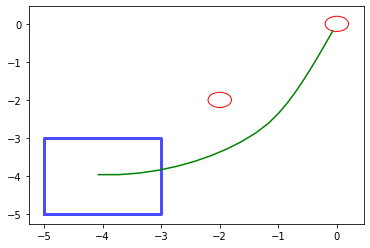

In [45]:
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(trajec[:,0],trajec[:,1], color= 'green')
ax = plt.gca()
ax.add_patch(plt.Circle((x_g_s[0], x_g_s[1]), 0.2, color='red', fill=False))
ax.add_patch(plt.Circle((xo[0], xo[1]), xo[2], color='red', fill=False))

In [25]:
# np.save('orig_traj', np.concatenate(trajectory))
# np.save('orig_traj_NN', np.concatenate(trajectory_NN))
# np.save('final_traj', np.concatenate(final_trajectory))
# np.save('orig_u', np.concatenate(control))
# np.save('final_u', np.concatenate(final_u))